# **Preprocesamiento de datos**

<a target="_blank" href="https://colab.research.google.com/github/daniel-lujan/intro-ia-project/blob/main/fase-1/02_Preprocesamiento.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## **Descarga del dataset**

In [ ]:
pip install ucimlrepo

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from ucimlrepo import fetch_ucirepo

census_income = fetch_ucirepo(id=20)

X = census_income.data.features
y = census_income.data.targets

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

## **Columnas y tipos de datos**

In [4]:
X.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
dtype: object

## **Tratamiento a valores faltantes**

Primero, debemos identificar si en el dataset faltan valores y decidir qué hacer con ellos en caso de existir.

In [5]:
for column in X.columns:
    if (num_nulls := X[column].isna().sum()):
        print(f'Column "{column}" has {num_nulls} nulls')

Column "workclass" has 963 nulls
Column "occupation" has 966 nulls
Column "native-country" has 274 nulls


Las 3 columnas encontradas con datos faltantes son categóricas.

### **Tratamiento para `workclass` y `native-country`**

En este caso, se decidió rellenar los valores faltantes con los valores más comunes. Esto con el motivo de que no existen muchas opciones fuera de las categorías existentes en el dataset para esa columna, y además, porque su valor, es **con mucha diferencia**, el más común, como se ve en los siguiente diagramas de barras:

In [6]:
print("Porcentaje de datos reemplazados para native-country: ", round(X["native-country"].isna().sum()* 100 / len(X), 2), "%")
print("Porcentaje de datos reemplazados para workclass: ", round(X["workclass"].isna().sum()* 100 / len(X), 2), "%")

Porcentaje de datos reemplazados para native-country:  0.56 %
Porcentaje de datos reemplazados para workclass:  1.97 %


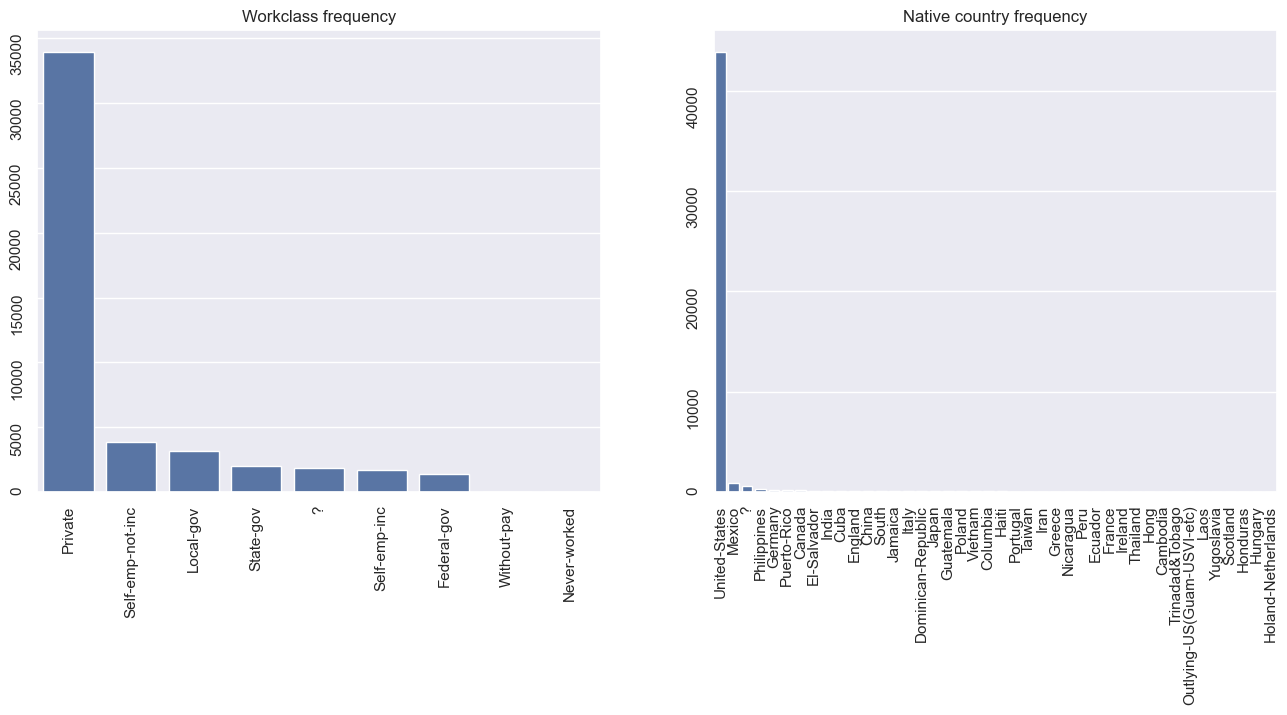

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
freq = X['workclass'].value_counts()
sns.barplot(x=freq.index, y=freq.values, ax=ax1)
ax1.tick_params(labelrotation=90)
ax1.set_title("Workclass frequency")
ax1.set_xlabel(None)

freq = X['native-country'].value_counts()
sns.barplot(x=freq.index, y=freq.values, ax=ax2)
ax2.tick_params(labelrotation=90)
ax2.set_title("Native country frequency")
ax2.set_xlabel(None)

plt.show()

In [8]:
def fill_nan_with_mode(column):
    mode = column.mode()[0]
    return column.fillna(mode)

X["workclass"] = fill_nan_with_mode(X["workclass"])
X["native-country"] = fill_nan_with_mode(X["native-country"])

Con esto, hemos eliminado los valores nulos de la columna, sin embargo, como se puede observar en el diagrama de barras, hay una categoría **`?`**, la cual hemos decidido interpretar también como valor nulo, y por tanto, le aplicamos el mismo tratamiento:

In [9]:
def fill_value_with_mode(column, value: str):
    mode = column.mode()[0]
    return column.replace(value, mode)

X["workclass"] = fill_value_with_mode(X["workclass"], "?")
X["native-country"] = fill_value_with_mode(X["native-country"], "?")

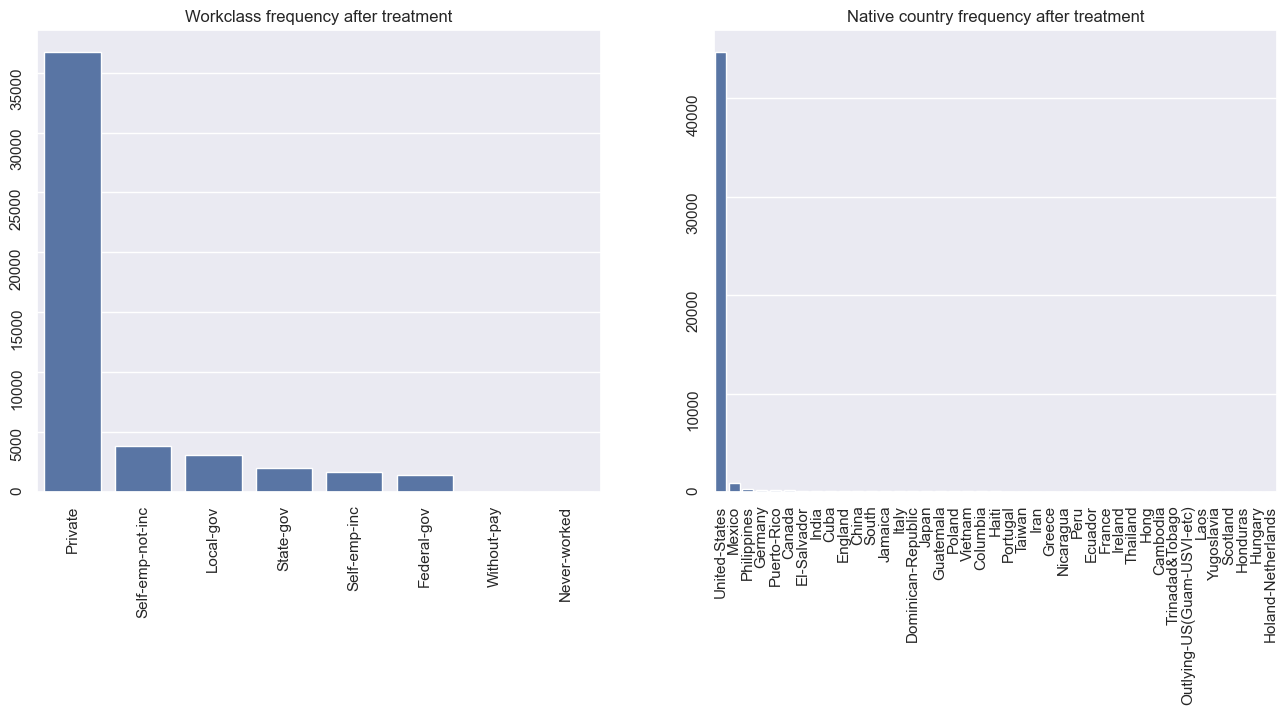

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
freq = X['workclass'].value_counts()
sns.barplot(x=freq.index, y=freq.values, ax=ax1)
ax1.tick_params(labelrotation=90)
ax1.set_title("Workclass frequency after treatment")
ax1.set_xlabel(None)

freq = X['native-country'].value_counts()
sns.barplot(x=freq.index, y=freq.values, ax=ax2)
ax2.tick_params(labelrotation=90)
ax2.set_title("Native country frequency after treatment")
ax2.set_xlabel(None)

plt.show()

### **Tratamiento para `occupation`**

En este caso, se decidió darle una nueva categoría para los registros con este dato faltante, debido a la probabilidad de que la ocupación real de la persona en cuestión este fuera de las categorías presentes en el dataset.

Para esta variable, ocurre lo mismo que para la anterior con la categoría **`?`**, nuevamente tratada como un valor nulo. Entonces, se reemplazaron los valores nulos con el valor de **`?`** y así conformar esta nueva categoría.

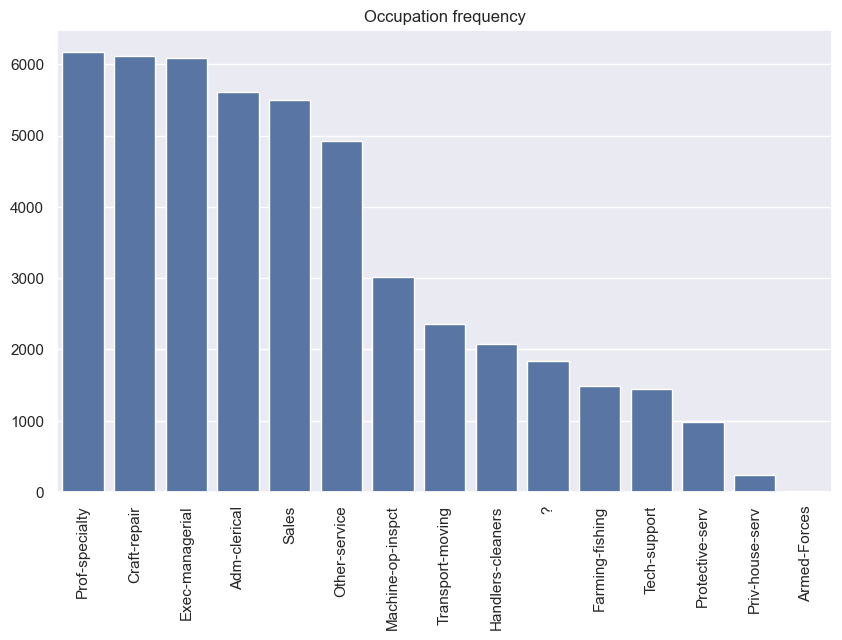

In [11]:
plt.figure(figsize=(10, 6))
freq = X['occupation'].value_counts()
sns.barplot(x=freq.index, y=freq.values)
plt.xticks(rotation='vertical')
plt.title("Occupation frequency")
plt.xlabel(None)

plt.show()

In [12]:
X["occupation"] = X["occupation"].fillna("?")

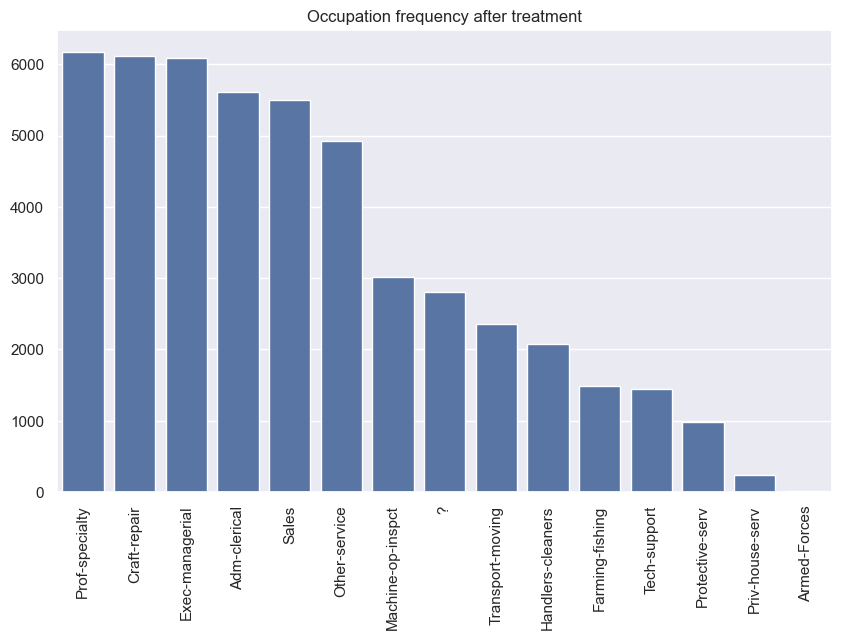

In [14]:
plt.figure(figsize=(10, 6))
freq = X['occupation'].value_counts()
sns.barplot(x=freq.index, y=freq.values)
plt.xticks(rotation='vertical')
plt.title("Occupation frequency after treatment")
plt.xlabel(None)

plt.show()

## **Eliminación de variables equivalentes**

Dentro del dataset encontramos dos variables que representan lo mismo:
- **`education`**: Describe categóricamente el nivel educativo de una persona.
- **`education-num`**: Describe numéricamente el nivel educativo de la persona en una escala de 1 a 16.

Para verificar que se hizo una transformación uno a uno, graficamos ambas variables y verificamos la equivalencia.

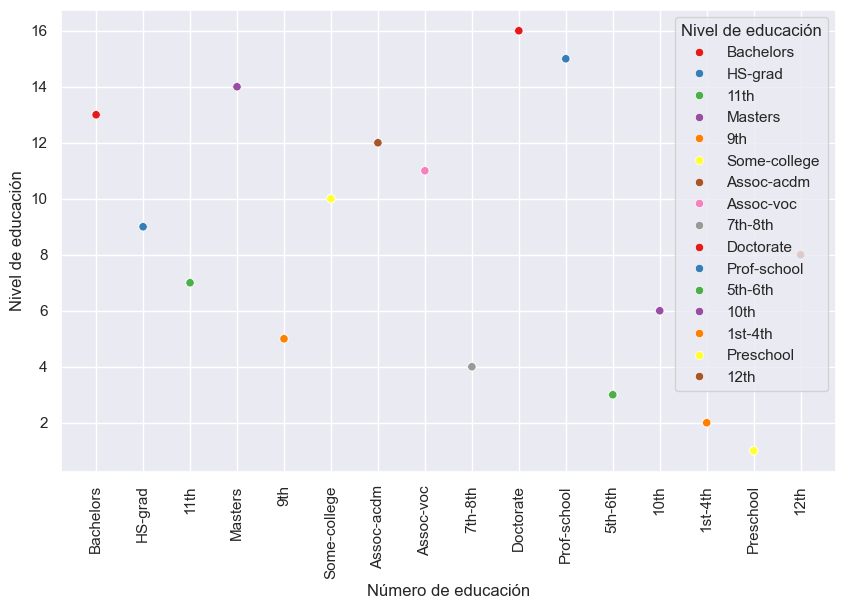

In [15]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='education', y='education-num', hue='education', data=X, palette='Set1')
plt.xlabel('Número de educación')
plt.ylabel('Nivel de educación')
plt.legend(title='Nivel de educación')
plt.xticks(rotation="vertical")
plt.show()

Efectivamente, se hizo una transofrmación uno a uno.

En este caso se decidió conservar la variable numérica, ya que puede aportar información más valiosa a un futuro modelo que la categórica dónde cada nivel de educación es una categoría independiente.

In [16]:
X.drop(columns=["education"], inplace=True)

## **Variable de salida**

In [17]:
def carac_muestras_clases(X, Y):
    """Esta funcion es encargada retornar el numero clases, muestras
        y caracteristicas del conjunto de datos X y Y

        X: matriz numpy con el conjunto de datos para entrenamiento
        Y: matriz numpy con el conjunto de etiquetas
        retorna:
            numero de caracteristicas (int/float)
            numero de muestras (int/float)
            numero de clases (int/float)

    """
    N, nf = X.shape
    clases = len(np.unique(Y))
    return (nf, N, clases)

In [18]:
print(carac_muestras_clases(X,y))

(13, 48842, 4)


Al obtener el número de clases se observa una anormalidad, ya que lo que estamos intentando predecir es de carácter binario, sin embargo hay 4 valores diferentes en la columna de salida.

In [19]:
np.unique(y)

array(['<=50K', '<=50K.', '>50K', '>50K.'], dtype=object)

**Para solucionar esto, normalizamos los valores `>50k.` y `<=50k.`, borrando el punto que tienen al final.**

In [20]:
y[y == ">50K."] = ">50K"
y[y == "<=50K."] = "<=50K"

**Verificamos el resultado:**

In [21]:
np.unique(y)

array(['<=50K', '>50K'], dtype=object)

In [22]:
carac_muestras_clases(X,y)

(13, 48842, 2)

**Ahora los cambiamos por ceros y unos tal que 1 si la persona gana más de 50 mil dólares y 0 de lo contrario**

In [23]:
y[y == ">50K"] = 1
y[y == "<=50K"] = 0

In [24]:
y = y.astype("int")

## **One hot encoding**

Para poder trabajar con el conjunto de datos, es necesario codificar las variables no-numéricas como números, para este fin, usamos one-hot encoding.

In [25]:
X = pd.get_dummies(X, columns=["workclass", "marital-status", "occupation", "relationship", "race", "sex", "native-country"])

## **Exportación de datos tratados**

In [26]:
X.to_pickle("./train-preprocessed.p")
y.to_pickle("./test-preprocessed.p")